In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define chaotic PRNG function
def chaotic_prng(r=3.9, x0=0.5, n=10):
    if not (0 < x0 < 1):
        raise ValueError("Initial value x0 must be between 0 and 1.")
    if not (0 < r <= 4):
        raise ValueError("Control parameter r must be between 0 and 4.")
    
    numbers = np.empty(n)
    x = x0
    for i in range(n):
        x = r * x * (1 - x)
        numbers[i] = x
    
    return numbers

# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.5 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Dynamic_Random_Graph class definition
class Dynamic_Random_Graph:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes
        
        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")
        
        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.history_positions = []  # Store positions over time
        self.create_graph()

    def create_graph(self):
        """Initialize the graph with nodes and edges based on positions."""
        for i in range(self.num_nodes):
            self.graph.add_node(i, pos=self.positions[i])
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def add_edge_based_on_position(self, i, j):
        """Add an edge based on node positions (closer nodes are more likely to form edges)."""
        distance = abs(self.positions[i] - self.positions[j])
        coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
        edge_probability = np.exp(-distance * coupling_constant_ij)  # Edge probability decreases with distance
        if np.random.rand() < edge_probability:
            self.graph.add_edge(i, j)

    def update_graph_edges(self):
        """Update the edges based on new node positions."""
        self.graph.clear_edges()
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def simulate_sde(self, mu, sigma, dt, num_steps):
        """Simulate the stochastic differential equation (SDE) and update node positions."""
        for _ in range(1, num_steps + 1):  # Start from 1 for indexing consistency
            dW = np.random.normal(scale=np.sqrt(dt), size=self.num_nodes)  # Use normal increments
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.history_positions.append(self.positions.copy())  # Store positions for each step
            self.update_graph_edges()  # Update edges after positions change

    def get_position_history(self):
        """Return the time history of node positions as a NumPy array."""
        return np.array(self.history_positions)

    def sample_distribution(self, num_samples):
        """Sample nodes based on their current positions."""
        probabilities = self.calculate_probabilities()
        bins = np.arange(self.num_nodes)
        samples = np.random.choice(bins, size=num_samples, p=probabilities)
        return samples

    def calculate_probabilities(self):
        """Calculate normalized probabilities based on current positions."""
        distances = np.abs(self.positions[:, np.newaxis] - self.positions)
        coupling_matrix = (self.coupling_constants[:, np.newaxis] + self.coupling_constants) / 2
        edge_probabilities = np.exp(-distances * coupling_matrix)  # Calculate edge probabilities
        total_edge_probabilities = edge_probabilities.sum(axis=1)
        probabilities = total_edge_probabilities / total_edge_probabilities.sum()  # Normalize
        return probabilities

    def check_normalization(self):
        """Check if the current probabilities sum to one."""
        probabilities = self.calculate_probabilities()
        return np.isclose(np.sum(probabilities), 1.0)

In [13]:
# Define peptide vocabulary
vocabulary = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Function to generate peptide sequences
def sample_peptide_sequences(dynamic_graph, num_peptides, peptide_length):
    peptides = []
    for _ in range(num_peptides):
        sampled_nodes = dynamic_graph.sample_distribution(peptide_length)
        peptide = ''.join(vocabulary[node] for node in sampled_nodes)
        peptides.append(peptide)
    return peptides

# Parameters
num_nodes = len(vocabulary)  # Set number of nodes equal to the size of the vocabulary
r = 1.5
x0 = 0.5
coupling_constants = chaotic_prng(r, x0, num_nodes)  # Generate chaotic coupling constants
dt = 0.01
num_steps = 10000

# Create dynamic random graph and simulate SDE dynamics
dynamic_graph = Dynamic_Random_Graph(num_nodes=num_nodes, coupling_constants=coupling_constants)
dynamic_graph.simulate_sde(mu, sigma, dt, num_steps)

In [14]:
# Peptide sampling parameters
peptide_length = 100  # Length of each peptide
num_peptides = 60   # Number of peptides to sample

# Sample peptides from the probability distribution
sampled_peptides = sample_peptide_sequences(dynamic_graph, num_peptides, peptide_length)

# Print the sampled peptide sequences
print("Sampled Peptide Sequences:")
for i, peptide in enumerate(sampled_peptides, 1):
    print(f"{i}: {peptide}")

Sampled Peptide Sequences:
1: WLSCFMILASGRNRLYTRNACGGRDGTHWPPSRDRCYIWRPHMEDPYPTAWHMEYHDPHMCAVDRYDEPYQHEPPAPSGKVGVMIRPHPGPVRKWGDLMI
2: FVIKKCNIMHMYYPTLQQEARSSPAWELSPMRMMFIYMWDPNFLADIYEIMETVTSENPPSFCYNMQSLWVCMWRLVGHYDPLYVERWQCHGCSVRCSGH
3: PQVIEVITHFRRQNHSYIHFGVNPHPTLIGVNSLFAKLHKPHDPSYAQFAITFWAYIRDSTQGKSCPMFWTQGNMMPHPAHSKWCANCTQNVLGLHMNLC
4: HEDELHNYSTKFAFRYHVHWKQFVKTNPAPEAWVQPGQQGLLQRFQGSYSGFPPLNWPDFLEPEFMQVITLSTQTLCKSRDRRRNLTKDWVSTHGMVMKN
5: NNAQENGEACQQRYYLYYNPSSNFYRVQGMQCACRSAMHSTCISDPMTHFMYDLKKYTHYIQSWENLMFLFFRLHYVHHDWDRRVPNKPVWPGIKTEILN
6: QWSCRQTEQQELEHNNHQYVEWGTHPCMVVYAYMWNYASEWFNVRHECALYPYAKHEEFFARHVYWEIGRHWRPDLAMTTRVWGFKVSLEVVVHHRVIRE
7: DWELPSYVVLSCHGPEKVKCENCEKMHSISNLFDMWWTNDKDHPNPAMIIYCLECQGVDIREAQTTHCTWADTIVAWWKLWPLPKREDMQKCSRIQDFFC
8: FTGAFAGHTFQMWIKTNYQPEQLWQERELVPSHDRTAPHGCLAKSQEMWMEFNAFENIPRHCARVYHYECHRGLMCKRRDVDERAQAANEFFRLSSPIQQ
9: GQWKVPEYYVWHTQAESSMDQESNMPKASTEYDHPRTYFVDPAWRVVHAACETQKEGTLVDDKHRMMFKLQEDENAPCVPFYSEWYVIKVKAHFTFTVDA
10: FPAILSSEDCIEEMWFFMIECDAIEPKDQWYFQ

([<matplotlib.axis.XTick at 0x7fb95d15fb20>,
 [Text(0, 0, 'A'),
  Text(1, 0, 'C'),
  Text(2, 0, 'D'),
  Text(3, 0, 'E'),
  Text(4, 0, 'F'),
  Text(5, 0, 'G'),
  Text(6, 0, 'H'),
  Text(7, 0, 'I'),
  Text(8, 0, 'K'),
  Text(9, 0, 'L'),
  Text(10, 0, 'M'),
  Text(11, 0, 'N'),
  Text(12, 0, 'P'),
  Text(13, 0, 'Q'),
  Text(14, 0, 'R'),
  Text(15, 0, 'S'),
  Text(16, 0, 'T'),
  Text(17, 0, 'V'),
  Text(18, 0, 'W'),
  Text(19, 0, 'Y')])

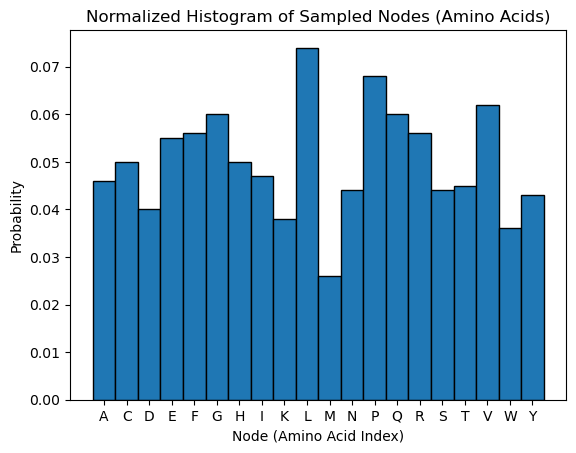

In [15]:
# Example usage: plot the distribution of sampled nodes (for visualization purposes)
samples = dynamic_graph.sample_distribution(num_samples=1000)
plt.hist(samples, bins=np.arange(dynamic_graph.num_nodes + 1) - 0.5, density=True, edgecolor='black')
plt.xlabel('Node (Amino Acid Index)')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Sampled Nodes (Amino Acids)')
plt.xticks(np.arange(dynamic_graph.num_nodes), vocabulary)

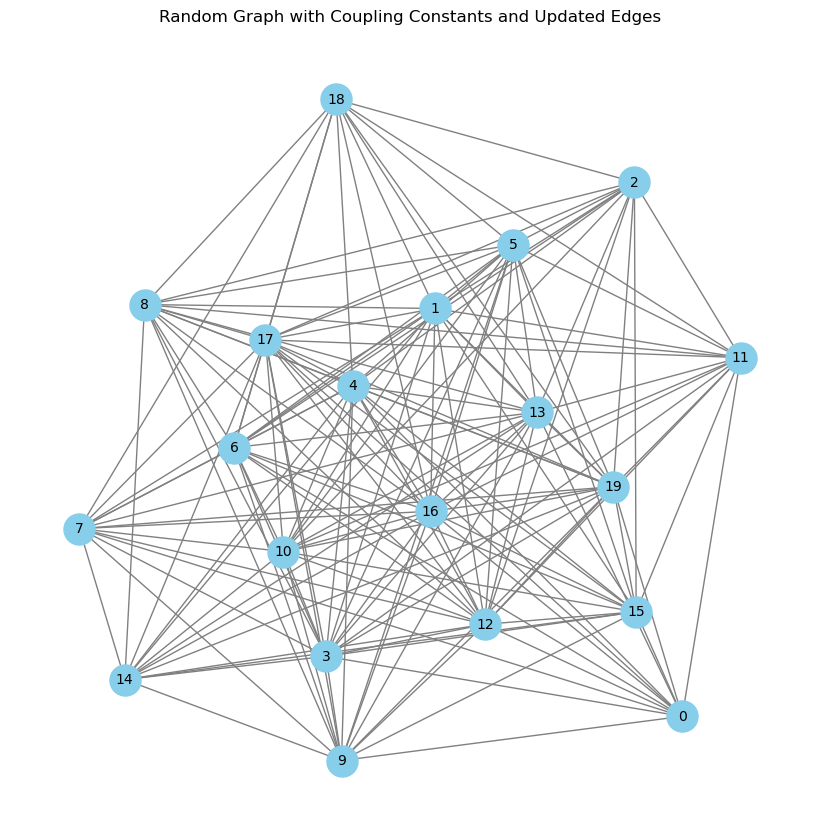

In [16]:
# Plotting the random graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(dynamic_graph.graph)  # Spring layout for better visualization
nx.draw(dynamic_graph.graph, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=10)
plt.title('Random Graph with Coupling Constants and Updated Edges')
plt.show()